In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy import stats
import prep, cf_matrix, models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, confusion_matrix, f1_score

In [9]:
df = pd.read_csv("../data/train.csv")
test_me = pd.read_csv("../data/test.csv")

# NETWORK INTRUSION DETECTION

##### This data is KDDCUP’99 data set, which is widely used as one of the few publicly available data sets for network-based anomaly detection systems.
##### For more about data: http://www.unb.ca/cic/datasets/nsl.html

<img src="../media/acknow.jpg" width="1080" height="400" />


## __LIST OF COLUMNS FOR THE DATA SET__

### __BASIC FEATURES OF EACH NETWORK CONNECTION VECTOR__

**1 Duration:** ``Length of time duration`` of the connection

**2 Protocol_type:** ``Protocol used`` in the connection

**3 Service:** ``Destination network service used``

**4 Flag:** ``Status`` of the connection – Normal or Error

**5 Src_bytes:** ``Number of data bytes`` transferred from ``source to destination`` in a single connection

**6 Dst_bytes:** ``Number of data bytes`` transferred from ``destination to source`` in a single connection

**7 Land:** if source and destination IP addresses and port numbers are equal then, this variable takes value 1
else 0

**8 Wrong_fragment:** Total ``number of wrong fragments`` in this connection

**9 Urgent:** ``Number of urgent packets`` in this connection. Urgent packets are packets with the urgent bit
activated


![](../media/two.jpg)

### __CONTENT RELATED FEATURES OF EACH NETWORK CONNECTION VECTOR__


**10 Hot:** Number of „hot‟ indicators in the content such as: ``entering a system directory, creating programs
and executing programs``

**11 Num_failed _logins:** ``Count of failed login attempts``

**12 Logged_in Login Status** : 1 if ``successfully logged in``; 0 otherwise

**13 Num_compromised** : ``Number of compromised``' ' conditions

**14 Root_shell:** 1 if ``root shell is obtained``; 0 otherwise

**15 Su_attempted:** 1 if ``su root'' command attempted or used``; 0 otherwise

**16 Num_root:** ``Number of root'' accesses or number of operations performed as a root in the connection``

**17 Num_file_creations:** ``Number of file creation operations`` in the connection

**18 Num_shells:** ``Number of shell prompts``

**19 Num_access_files** : ``Number of operations on access control files``

**20 Num_outbound_cmds:** ``Number of outbound commands in an ftp session``

**21 Is_hot_login:** 1 if the ``login belongs to the hot'' list i.e., root or admin``; else 0

**22 Is_guest_login:** 1 if the ``login is a guest``'' login; 0 otherwise


<img src="../media/three.gif" width="1080" height="400" />


### __TIME-RELATED TRAFFIC FEATURES OF EACH NETWORK CONNECTION VECTOR__

**23 Count:** ``Number of connections to the same destination host as the current connection`` in the past two
seconds

**24 Srv_count:** ``Number of connections to the same service (port number) as the current connection`` in the
past two seconds

**25 Serror_rate:** ``The percentage of connections that have activated`` the flag (4) s0, s1, s2 or s3, among the
connections aggregated in ``count`` (23)

**26 Srv_serror_rate:** ``The percentage of connections that have activated the flag`` (4) s0, s1, s2 or s3, among
the connections aggregated in ``srv_count`` (24)

**27 Rerror_rate:** ``The percentage of connections that have activated the flag`` (4) REJ, among the connections
aggregated in ``count`` (23)

**28 Srv_rerror_rate:** ``The percentage of connections that have activated the flag`` (4) REJ, among the
connections aggregated in ``srv_count`` (24)

**29 Same_srv_rate:** ``The percentage of connections that were to the same service``, among the connections
aggregated in ``count`` (23)

**30 Diff_srv_rate:** ``The percentage of connections that were to different services``, among the connections
aggregated in ``count`` (23)

**31 Srv_diff_host_ rate:** ``The percentage of connections that were to different destination machines`` among
the connections aggregated in ``srv_count`` (24)

### __HOST BASED TRAFFIC FEATURES IN A NETWORK CONNECTION VECTOR__

**32 Dst_host_count:** Number of connections having the ``same destination host IP address``

**33 Dst_host_srv_ count:** Number of connections having the ``same port number``

**34 Dst_host_same _srv_rate:** ``The percentage of connections that were to the same service``, among the
connections aggregated in ``dst_host_count`` (32)

**35 Dst_host_diff_ srv_rate:** ``The percentage of connections that were to different services``, among the
connections aggregated in ``dst_host_count`` (32)

**36 Dst_host_same _src_port_rate** : ``The percentage of connections that were to the same source port``,
among the connections aggregated in ``dst_host_srv_count`` (33)

**37 Dst_host_srv_ diff_host_rate:** ``The percentage of connections that were to different destination
machines``, among the connections aggregated in ``dst_host_srv_count`` (33)

**38 Dst_host_serror_rate:** ``The percentage of connections that have activated the flag`` (4) s0, s1, s2 or s3,
among the connections aggregated in ``dst_host_count`` (32)

**39 Dst_host_srv_s error_rate:** ``The percent of connections that have activated the flag`` (4) s0, s1, s2 or s3,
among the connections aggregated in ``dst_host_srv_c ount`` (33)

**40 Dst_host_rerro r_rate** : ``The percentage of connections that have activated the flag`` (4) REJ, among the
connections aggregated in ``dst_host_count`` (32)

**41 Dst_host_srv_r error_rate:** ``The percentage of connections that have activated the flag`` (4) REJ, among
the connections aggregated in ``dst_host_srv_count`` (33)


### __ATTACK CLASS__
<img src="../media/hack.jpg" width="1080" height="400" />


**1. DOS:** Denial of service is an attack category, which depletes the victim‟s resources thereby making it
unable to handle legitimate requests – e.g. syn flooding. Relevant features: ``source bytes`` and ``percentage of packets with errors``

**2. Probing:** Surveillance and another probing attack ‟s objective is to gain information about the remote victim
e.g. port scanning. Relevant features: ``duration of connection`` and ``source bytes``

**3. U2R:** unauthorized access to local superuser (root) privileges is an attack-type, by which an attacker uses
a normal account to login into a victim system and tries to gain root/administrator privileges by exploiting
some vulnerability in the victim e.g. buffer overflow attacks. Relevant features: ``number of file creations``
and ``number of shell prompts invoked``

**4. R2L:** unauthorized access from a remote machine, the attacker intrudes into a remote machine and gains
local access of the victim machine. E.g. password guessing Relevant features: Network-level features –
“duration of connection” and “service requested” and host level features - ``number of failed login
attempts``


In [10]:
def change_target_variable(df):
    attacks = {
    'dos': ['back', 'land', 'neptune', 
            'pod', 'smurf', 'teardrop', 
            'apache2', 'udpstorm', 'processtable', 
            'worm'],
    'probe': ['satan', 'ipsweep', 'nmap', 
              'portsweep', 'mscan', 'saint'],
    'r2l': ['guess_passwd', 'ftp_write', 'imap',
            'phf', 'multihop', 'warezmaster',
            'warezclient', 'spy', 'xlock',
            'xsnoop', 'snmpguess', 'snmpgetattack',
            'httptunnel', 'sendmail', 'named'],
    'u2r': ['buffer_overflow', 'loadmodule', 'rootkit', 
            'perl', 'sqlattack', 'xterm', 'ps']
    }
    df["attacks_class"] = np.nan
    for each_attack_type in attacks.keys():
        df.loc[df[df.attack.isin(attacks[each_attack_type])].index, "attacks_class"] = each_attack_type
    df.attacks_class.fillna('normal', inplace = True)
    df.drop("attack", axis = 1 ,inplace =True)
    return df

def evaluate_metric(X, y, weight, model):
    if model.__class__.__name__ == 'Pipeline':
        upper = [' '.join([each_step for each_step, _ in model.steps])]
        
    else:
        upper = [model.__class__.__name__]
        
    model_eval =  pd.DataFrame({
        event: [
            roc_auc_score(pd.get_dummies(y).values[:,_], model.predict_proba(X)[:,_]), 
            log_loss(pd.get_dummies(y).values[:,_], model.predict_proba(X)[:,_]), 
            f1_score(pd.get_dummies(y).values[:,_], model.predict_proba(X)[:,_]>weight[event])
        ] 
        for _, event in enumerate(['normal', 'dos', 'probe', 'r2l', 'u2r'])
    }, index = ["ROC", "Log Loss", "F1 Score"])
    model_eval.columns = pd.MultiIndex.from_product([upper, model_eval.columns])
    return model_eval

def evaluate_all_models(train_X, train_y,test_X,test_y,weight):
    MODELS_EVAL = pd.DataFrame()
    for each_model in models.MODELS:
        print(f"Started {each_model.__class__.__name__}")
        each_model.fit(train_X, train_y)
        MODELS_EVAL = pd.concat([MODELS_EVAL, evaluate_metric(test_X,test_y,weight, each_model)], axis = 1)
        print(f"Ended {each_model.__class__.__name__}")
        
    return MODELS_EVAL.T

In [11]:
df = change_target_variable(df)

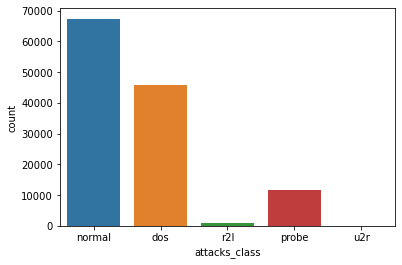

In [12]:
sns.countplot(df.attacks_class)
plt.show()

### Status of the connection – Normal or Error __(flag)__ during __DOS__ attack 

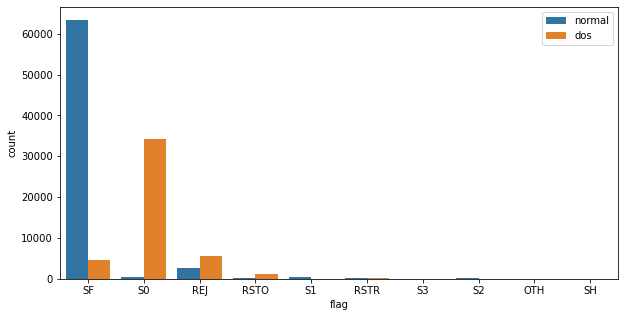

In [13]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'flag', hue= 'attacks_class', data = df.loc[df.attacks_class.isin(["normal","dos"]), ["attacks_class", "flag"]])
plt.legend(loc = 'upper right')
plt.show()

### Number of data bytes transferred from source to destination in a single connection __(src_bytes)__ during __Probe__ attack 

In [14]:
df.loc[df.attacks_class.isin(["normal","probe"]), ["attacks_class", "src_bytes"]].groupby("attacks_class").describe()

src_bytes                                                  \
                  count           mean           std  min    25%    50%   
attacks_class                                                             
normal          67343.0   13133.279331  4.181131e+05  0.0  129.0  233.0   
probe           11656.0  385679.838367  1.926641e+07  0.0    0.0    1.0   

                                    
                 75%           max  
attacks_class                       
normal         324.0  8.958152e+07  
probe            8.0  1.379964e+09

In [15]:
stats.ttest_ind(df.loc[df.attacks_class == 'normal', "src_bytes"], df.loc[df.attacks_class == 'probe', "src_bytes"])

Ttest_indResult(statistic=-5.011283459705361, pvalue=5.418467887134679e-07)

### Length of time duration of the connection __(Duration)__ during __Probe__ attack 

In [16]:
df.loc[df.attacks_class.isin(["normal","probe"]), ["attacks_class", "duration"]].groupby("attacks_class").describe()

duration                                                       
                 count         mean          std  min  25%  50%  75%      max
attacks_class                                                                
normal         67343.0   168.587396  1304.452127  0.0  0.0  0.0  0.0  40504.0
probe          11656.0  2074.858185  7710.333068  0.0  0.0  0.0  0.0  42908.0

In [17]:
stats.ttest_ind(df.loc[df.attacks_class == 'normal', "duration"], df.loc[df.attacks_class == 'probe', "duration"])

Ttest_indResult(statistic=-59.434276798085186, pvalue=0.0)

### Number of shell prompts __(num_shell)__ during __U2R__ attacks 

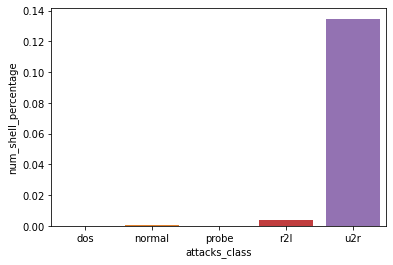

In [18]:
_ = pd.DataFrame(df.groupby('attacks_class')['num_shells'].sum() / df.attacks_class.value_counts()).reset_index()
_.columns = ['attacks_class', 'num_shell_percentage']
sns.barplot(x = 'attacks_class', y = 'num_shell_percentage', data = _)
plt.show()

### Number of file creation operations in the connection __(num_file_creations)__ during __U2R__ attacks 

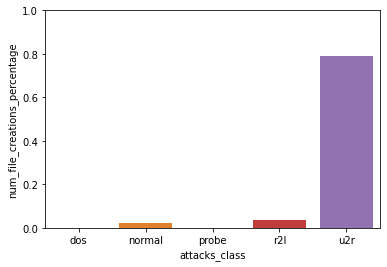

In [19]:
_ = pd.DataFrame(df.groupby('attacks_class')['num_file_creations'].sum() / df.attacks_class.value_counts()).reset_index()
_.columns = ['attacks_class', 'num_file_creations_percentage']
sns.barplot(x = 'attacks_class', y = 'num_file_creations_percentage', data = _)
plt.ylim(0,1)
plt.show()

### Count of failed login attempts __(num_failed_logins)__ during different attacks 

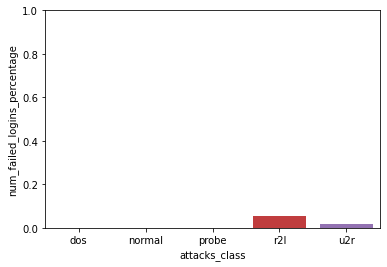

In [20]:
_ = pd.DataFrame(df.groupby('attacks_class')['num_failed_logins'].sum() / df.attacks_class.value_counts()).reset_index()
_.columns = ['attacks_class', 'num_failed_logins_percentage']
sns.barplot(x = 'attacks_class', y = 'num_failed_logins_percentage', data = _)
plt.ylim(0,1)
plt.show()

In [21]:
df = prep.prep(df)
X = df.iloc[:, :-1]
y = df.attacks_class

In [22]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, stratify= y)

In [23]:
train_y.value_counts()/train_y.shape

normal    0.534582
dos       0.364580
probe     0.092526
r2l       0.007904
u2r       0.000408
Name: attacks_class, dtype: float64

In [24]:
train_X.shape

(88181, 120)

In [25]:
weight = {
    "normal"   :0.534582,
    "dos"      :0.364580,
    "probe"    :0.092526,
    "r2l"      :0.007904,
    "u2r"      :0.000408
}

In [26]:
evaluate_all_models(train_X, train_y, test_X, test_y, weight)

Started RandomForestClassifier
Ended RandomForestClassifier
Started Pipeline
Ended Pipeline
Started Pipeline
Ended Pipeline
Started LogisticRegression
Ended LogisticRegression


ROC  Log Loss  F1 Score
RandomForestClassifier                 normal  1.000000  0.001088  0.999819
                                       dos     0.999999  0.003142  0.999332
                                       probe   0.999999  0.001916  0.988691
                                       r2l     0.999975  0.001293  0.479100
                                       u2r     0.999909  0.000559  0.142222
PCA RandomForestClassifier             normal  1.000000  0.001901  0.999782
                                       dos     0.999998  0.004227  0.999208
                                       probe   0.999999  0.003029  0.983408
                                       r2l     0.999972  0.001674  0.449472
                                       u2r     0.999944  0.000531  0.091168
Standard Scaler RandomForestClassifier normal  1.000000  0.001035  0.999855
                                       dos     0.999999  0.003097  0.999382
                                       probe   0.999999  0.001886  0.989810
                                       r2l     0.999970  0.001313  0.500840
                                       u2r     0.999938  0.000526  0.129555
LogisticRegression                     normal  0.945070  0.490506  0.792486
                                       dos     0.946047  0.359029  0.850490
                                       probe   0.759258  0.313774  0.346760
                                       r2l     0.621065  0.103285  0.015391
                                       u2r     0.192053  0.036214  0.000170

In [27]:
rfc = RandomForestClassifier(oob_score= True, n_jobs= -1, verbose= 0, class_weight= weight)

In [28]:
rfc.fit(train_X, train_y)

RandomForestClassifier(class_weight={'dos': 0.36458, 'normal': 0.534582,
                                     'probe': 0.092526, 'r2l': 0.007904,
                                     'u2r': 0.000408},
                       n_jobs=-1, oob_score=True)

In [42]:
print("\n\n","-"*20, " Validation Set ","-"*20, "\n\n")
evaluate_metric(test_X,test_y,weight, rfc)



 --------------------  Validation Set  -------------------- 




,normal,dos,probe,r2l,u2r
ROC,1.000000,0.999999,0.999999,0.999995,0.999925
Log Loss,0.001064,0.003305,0.002101,0.001173,0.000522
F1 Score,0.999819,0.999332,0.987993,0.485342,0.115942


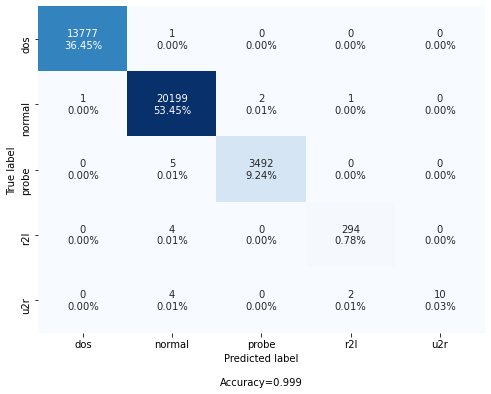

In [25]:
cf_matrix.make_confusion_matrix(
    confusion_matrix(test_y, rfc.predict(test_X)), 
    figsize=(8,6), 
    categories=["dos", "normal", "probe", "r2l", "u2r"], 
    cbar=False
)

In [26]:
test_me = change_target_variable(test_me)

In [27]:
test_me = prep.prep(test_me)
X = df.iloc[:, :-1]
y = df.attacks_class

In [51]:
print("\n\n","-"*20, " Test Set ","-"*20, "\n\n")
evaluate_metric(X,y,weight, rfc)



 --------------------  Test Set  -------------------- 




RandomForestClassifier                                        
                         normal       dos     probe       r2l       u2r
ROC                    1.000000  1.000000  1.000000  0.999999  0.999987
Log Loss               0.000565  0.001754  0.001066  0.000651  0.000254
F1 Score               0.999946  0.999800  0.994964  0.583236  0.172471

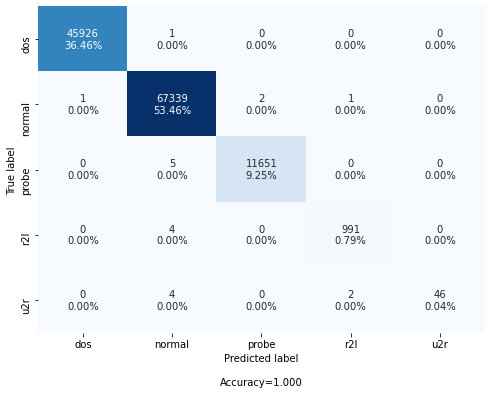

In [30]:
cf_matrix.make_confusion_matrix(
    confusion_matrix(y, rfc.predict(X)), 
    figsize=(8,6), 
    categories=["dos", "normal", "probe", "r2l", "u2r"], 
    cbar=False
)

In [33]:
Feature_imp = pd.DataFrame()
Feature_imp["Feature"] = train_X.columns
Feature_imp["Imp"] = rfc.feature_importances_

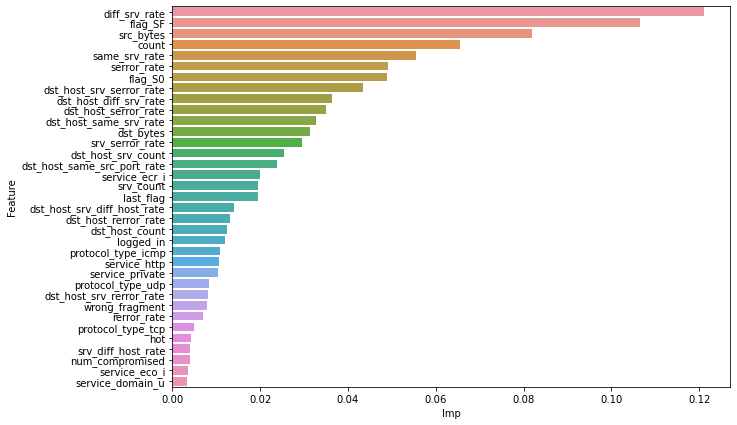

In [34]:
plt.figure(figsize=(10,7))
_ = round(Feature_imp.sort_values("Imp", ascending= False), 5).iloc[:35, :]
sns.barplot(x = "Imp", y ="Feature", data = _)
plt.show()

### Feature helped in classifying Normal or DOS attacks

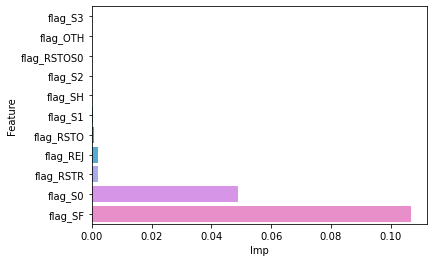

In [35]:
_ = Feature_imp[Feature_imp.Feature.str.find("flag_") != -1].sort_values("Imp")
sns.barplot(x = "Imp", y = "Feature",data = _)
plt.show()

### Feature helped in classifying Probe, U2R and R2L attacks 

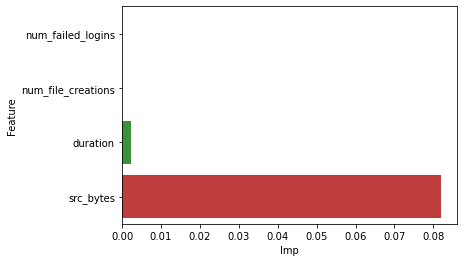

In [36]:
_ = Feature_imp[Feature_imp.Feature.isin(["num_shell", "src_bytes", "duration","num_file_creations","num_failed_logins"])].sort_values("Imp")
sns.barplot(x = "Imp", y ="Feature", data = _)
plt.show()